In [1]:
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
plt.rcParams['font.family'] = 'serif'

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [29]:
from factorgp import FactorGP
from inference import run_gibbs

## Data simulation

Here we simulate data with a two-dimensional latent Gaussian process. We map the latent curves to 15 dimensions with a loading matrix and add random noise. This would be the estimated log-covariance series of 5 x 5 covariance matrices. The data have 30 time points in each replication and there are 5 replications (different realizations of the same GP). The true latent curves and noisy log-covariance series are plotted for the first replication below.

In [13]:
n = 5  # number of replications
t = 30  # number of time points
q = 15  # dimensions of log-covariance
r = 2  # latent dimensions

In [14]:
gp = GaussianProcessRegressor(kernel=RBF(length_scale=5))
x = np.linspace(1, t, t)
curves = gp.sample_y(x.reshape((t, 1)), n * r)  # draw latent curves from Gaussian process

In [6]:
F = np.zeros((n * t, r))  # re-format data for modeling 
for i in range(n):
    for j in range(r):
        F[(i * t):(i * t + t), j] = curves[:, (i * r + j)]  # stack curves together from all the replications

In [ ]:
loading = np.random.normal(0, 1, [r, q])
Y_true = np.matmul(F, loading)
Y = Y_true + np.random.normal(0, 0.5, [n * t, q])  # multiply by loading matrix and add random noise

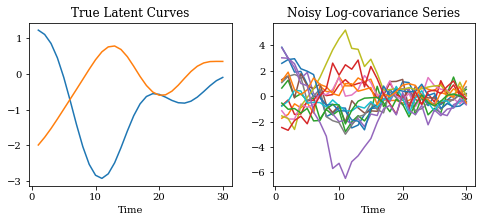

In [42]:
fig = plt.figure(figsize=(8, 3))

plt.subplot(121)
for j in range(r):
    plt.plot(x, F[:t, j])
plt.title('True Latent Curves')
plt.xlabel('Time')

plt.subplot(122)
for j in range(q):
    plt.plot(x, Y[:t, j])
plt.title('Noisy Log-covariance Series')
plt.xlabel('Time')

plt.show()

## Model fitting

We can fit the latent factor GP model with default diffused priors and run Gibbs sampling for 1000 iterations. Within each iteration, Metropolis-Hastings random walk with 50 steps of size 0.5 is used for the GP length scales. All the samples and MSE history are stored in results.

In [11]:
dims = [n, t, q, r]  # n, t, q, r are the same as before
model = FactorGP(dims)  # create latent factor GP model
model.update_conditional_latent(Y)  # start with latent curves conditonal on prior distributions

In [12]:
results = run_gibbs(Y, model, 1000, 50, 0.5, verbose=False)

  0%|          | 0/1000 [00:00<?, ?it/s]metropolis.py:69: RuntimeWarning: overflow encountered in exp
  if accept_new(np.exp(p_new - p)):
100%|██████████| 1000/1000 [13:59<00:00,  1.27it/s]


In [16]:
F_sample, loading_sample, variance_sample, theta_sample, traces_hist, mse_history = results

## Results

The MCMC chains for the GP length scales seem to converge after 200 iterations and are mixing well around 5 (the true length scale value).

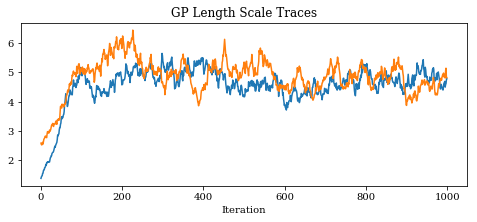

In [43]:
fig = plt.figure(figsize=(8, 3))
for j in range(2):
    plt.plot(theta_sample[:, j])
plt.title('GP Length Scale Traces')
plt.xlabel('Iteration')
plt.show()

We can look at the posterior distributions of latent factors and they are very close to the true latent curves (up to a scaling constant) as expected. The posterior distributions of the length scales sufficiently diverge from the Gamma(10, 1) prior and are concentrated near the true value, which is 5.

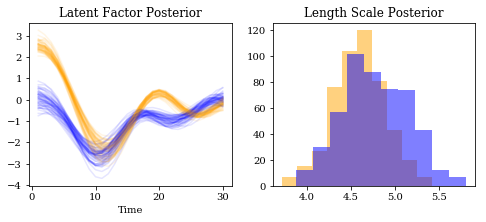

In [45]:
burn = 500  # discard the first 500 MCMC samples
thin = 10  # take every 10th MCMC sample

fig = plt.figure(figsize=(8, 3))

plt.subplot(121)
for i in range(50):
    plt.plot(x, F_sample[burn + i * thin, :30, 0], color='orange', alpha=0.1)
    plt.plot(x, F_sample[burn + i * thin, :30, 1], color='blue', alpha=0.1)
plt.title('Latent Factor Posterior')
plt.xlabel('Time')

plt.subplot(122)
plt.hist(theta_sample[burn:, 0], bins=10, alpha=0.5, color='orange')
plt.hist(theta_sample[burn:, 1], bins=10, alpha=0.5, color='blue')
plt.title('Length Scale Posterior')

plt.show()